In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr

In [3]:
# Normalization with sca
def stand_sca(data):
    new_data=(data-data.mean())/data.std()
    return new_data

In [7]:
#读入数据为dataframe格式，并做0均值1标准差处理
df_result = pd.read_excel(r'Benguela-FAO.xlsx')
df_result = df_result.drop(columns=['year','region-FAO'])
df_result = stand_sca(df_result)
df_result.head()

,A.landing-sum,S.landing-sum,temp,sea_level
0,-1.289112,-0.283235,-0.474427,-1.350878
1,-1.289621,-0.253492,-1.174282,-1.303344
2,-1.289621,-0.422280,-1.287081,-1.263061
3,-1.289367,-0.448660,-2.477009,-1.241711
4,-1.289367,0.093332,-2.169374,-1.206262


In [3]:
var_names = [r'$anchovy$', r'$sardine$', r'$sio_sst$', r'$np_sst$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names)

print(dataframe)

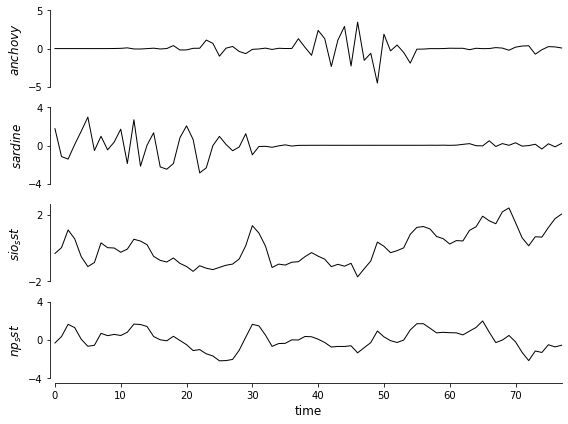

In [4]:
tp.plot_timeseries(dataframe, figsize=(8, 6)); plt.show()

In [5]:
# use Partial Correlation as the Conditional Independence test
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 10


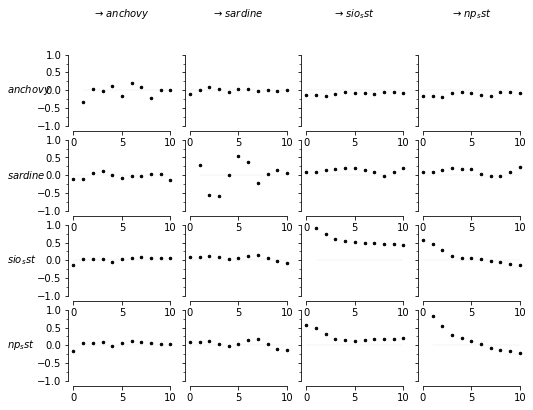

In [6]:
# plot the the lagged correlations
correlations = pcmci.get_lagged_dependencies(tau_max=10, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5, 'figsize':(8, 6)}); plt.show()

In [7]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=5, pc_alpha=None) # 设置成none：传入默认的pc_alpha列表，对每个变量用AIC算法找到optimal alpha


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
    [pc_alpha = 0.05]
        ($anchovy$ -1): max_pval = 0.00621, min_val = -0.329

    Variable $sardine$ has 3 link(s):
    [pc_alpha = 0.2]
        ($sardine$ -5): max_pval = 0.00010, min_val =  0.456
        ($np_sst$ -4): max_pval = 0.13582, min_val = -0.183
        ($sardine$ -3): max_pval = 0.17063, min_val = -0.171

    Variable $sio_sst$ has 2 link(s):
    [pc_alpha = 0.05]
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.782
        ($np_sst$ -2): max_pval = 0.03833, min_val =  0.252

    Variable $np_sst$ has 2 link(s):
    [pc_alpha = 0.05]
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.766
        ($np_sst$ -2): max_pval = 0.01581, min_val = -0.296

##
## Step 2: MCI algori

In [8]:
print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[1.    0.005 0.344 0.97  0.61  0.397]
  [0.764 0.712 0.922 0.94  0.848 0.864]
  [0.001 0.978 0.521 0.422 0.765 0.298]
  [0.003 0.649 0.446 0.252 0.31  0.254]]

 [[0.764 0.431 0.748 0.286 0.866 0.985]
  [1.    0.933 0.261 0.138 0.217 0.   ]
  [0.859 0.549 0.124 0.716 0.789 0.842]
  [0.846 0.756 0.133 0.784 0.825 0.914]]

 [[0.001 0.653 0.799 0.07  0.582 0.651]
  [0.859 0.802 0.835 0.094 0.686 0.216]
  [1.    0.    0.894 0.002 0.431 0.71 ]
  [0.    0.741 0.254 0.    0.034 0.403]]

 [[0.003 0.387 0.703 0.102 0.922 0.582]
  [0.846 0.736 0.936 0.172 0.07  0.191]
  [0.    0.256 0.267 0.136 0.274 0.526]
  [1.    0.    0.089 0.015 0.009 0.238]]]
MCI partial correlations
[[[ 0.   -0.34 -0.12  0.    0.06 -0.11]
  [-0.04  0.05  0.01 -0.01 -0.02  0.02]
  [-0.41  0.   -0.08  0.1  -0.04 -0.13]
  [-0.36  0.06 -0.1   0.14 -0.13 -0.14]]

 [[-0.04 -0.1   0.04  0.14  0.02 -0.  ]
  [ 0.   -0.01 -0.14 -0.19 -0.16  0.47]
  [-0.02  0.08  0.2   0.05 -0.03 -0.03]
  [ 0.02  0.04  0.19  0.04 -0.03 -0.

In [9]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=5, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $anchovy$ has 2 link(s):
        ($sio_sst$  0): pval = 0.00082 | val = -0.405
        ($np_sst$  0): pval = 0.00344 | val = -0.358

    Variable $sardine$ has 1 link(s):
        ($sardine$ -5): pval = 0.00247 | val =  0.472

    Variable $sio_sst$ has 3 link(s):
        ($np_sst$  0): pval = 0.00000 | val =  0.849
        ($sio_sst$ -1): pval = 0.00000 | val =  0.764
        ($anchovy$  0): pval = 0.00082 | val = -0.405

    Variable $np_sst$ has 4 link(s):
        ($sio_sst$  0): pval = 0.00000 | val =  0.849
        ($np_sst$ -1): pval = 0.00000 | val =  0.766
        ($sio_sst$ -3): pval = 0.00408 | val = -0.448
        ($anchovy$  0): pval = 0.00344 | val = -0.358


In [10]:
link_matrix = pcmci.run_pcmci(tau_max=5, pc_alpha = None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
    [pc_alpha = 0.05]
        ($anchovy$ -1): max_pval = 0.00621, min_val = -0.329

    Variable $sardine$ has 3 link(s):
    [pc_alpha = 0.2]
        ($sardine$ -5): max_pval = 0.00010, min_val =  0.456
        ($np_sst$ -4): max_pval = 0.13582, min_val = -0.183
        ($sardine$ -3): max_pval = 0.17063, min_val = -0.171

    Variable $sio_sst$ has 2 link(s):
    [pc_alpha = 0.05]
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.782
        ($np_sst$ -2): max_pval = 0.03833, min_val =  0.252

    Variable $np_sst$ has 2 link(s):
    [pc_alpha = 0.05]
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.766
        ($np_sst$ -2): max_pval = 0.01581, min_val = -0.296

##
## Step 2: MCI algori

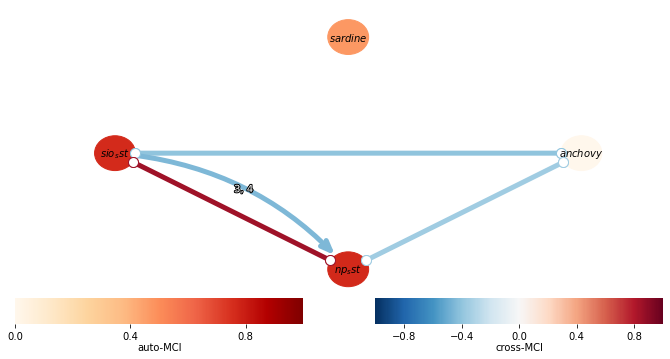

In [11]:
tp.plot_graph(
    figsize=(10,6),
    graph=link_matrix.get("graph"),
    val_matrix=link_matrix['val_matrix'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

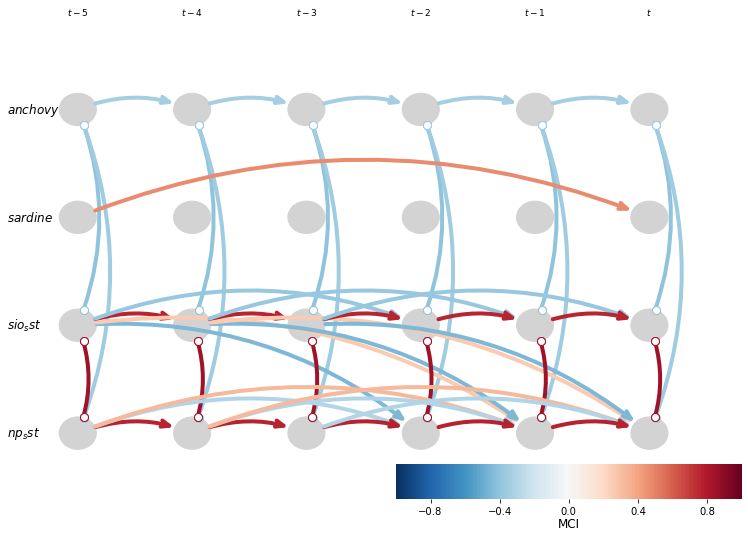

In [12]:
# Plot time series graph    
tp.plot_time_series_graph(
    graph=link_matrix.get("graph"),
    figsize=(12, 8),
    val_matrix=link_matrix['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

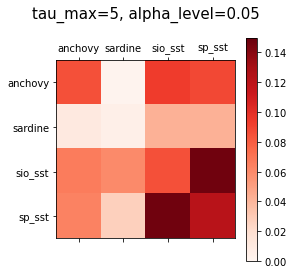

In [14]:
im2 = plt.matshow(mci, cmap=plt.cm.Reds, norm = matplotlib.colors.Normalize(vmin=0, vmax=0.15, clip=False))
cb2 = plt.colorbar(im2)

labels=['anchovy','sardine','sio_sst','sp_sst']
plt.yticks(range(0,4,1), labels=labels)
plt.xticks(range(0,4,1), labels=labels)
plt.title('tau_max=5, alpha_level=0.05', y=1.2, fontsize=15)
plt.show()

In [30]:
# Humboldt, NE Atlantic, KO, California, Benguela, Brazil-Argentina, 
TAmatrix = [[0.562142857, 0.669285714, 0.556607143, 0.318333333, 0.601607143, 0.553061224], [0.590178571, 0.55625, 0.5275, 0.3065, 0.561071429, 0.598163265
]]

([<matplotlib.axis.YTick at 0x1834f768880>,
 [Text(0, 0, 'Temperature-Anchovy'), Text(0, 1, 'SeaLevelRise-Anchovy')])

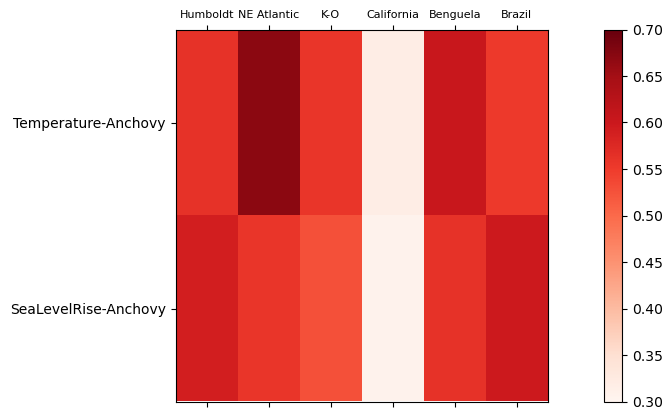

In [33]:
fig1 = plt.matshow(TAmatrix, cmap=plt.cm.Reds, aspect=3, norm = matplotlib.colors.Normalize(vmin=0.3, vmax=0.7, clip=False))
plt.colorbar(fig1)
labels=['Humboldt','NE Atlantic','K-O','California','Benguela','Brazil']
plt.xticks(range(0,6,1), labels=labels, fontsize=8)
plt.yticks(range(0,2,1), labels=['Temperature-Anchovy', 'SeaLevelRise-Anchovy'])

In [34]:
# Humboldt, NE Atlantic, KO, California, Benguela, Brazil-Argentina, 
TSmatrix = [[0.638214286, 0.699642857, 0.670357143, 0.383833333, 0.690535714, 0.621836735], [0.613035714, 0.681071429, 0.493928571, 0.412666667, 0.690714286, 0.650408163
]]

([<matplotlib.axis.YTick at 0x1834f3ebeb0>,
 [Text(0, 0, 'Temperature-Sardine'), Text(0, 1, 'SeaLevelRise-Sardine')])

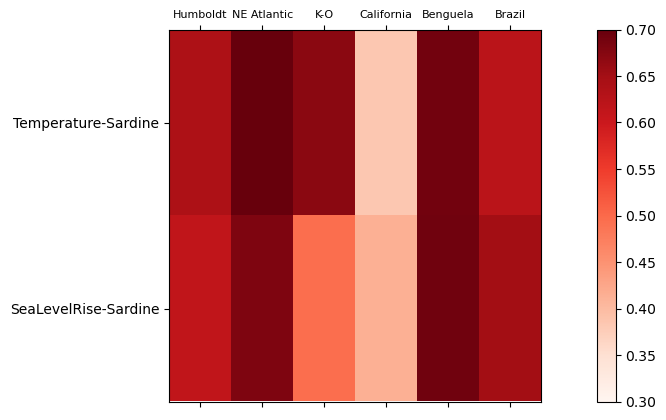

In [40]:
fig2 = plt.matshow(TSmatrix, cmap=plt.cm.Reds, aspect=3, norm = matplotlib.colors.Normalize(vmin=0.3, vmax=0.7, clip=False))
plt.colorbar(fig2)
labels=['Humboldt','NE Atlantic','K-O','California','Benguela','Brazil']
plt.xticks(range(0,6,1), labels=labels, fontsize=8)
plt.yticks(range(0,2,1), labels=['Temperature-Sardine', 'SeaLevelRise-Sardine'])

In [37]:
# Humboldt, NE Atlantic, KO, California, Benguela, Brazil-Argentina, 
TA1matrix = [[0.189,0.130,0.166,0.160,0.076,0.090], [0.084,0.183,0.083,0.070,0.120,0.104]]

([<matplotlib.axis.YTick at 0x18351299eb0>,
 [Text(0, 0, 'Temperature-Anchovy'), Text(0, 1, 'SeaLevelRise-Anchovy')])

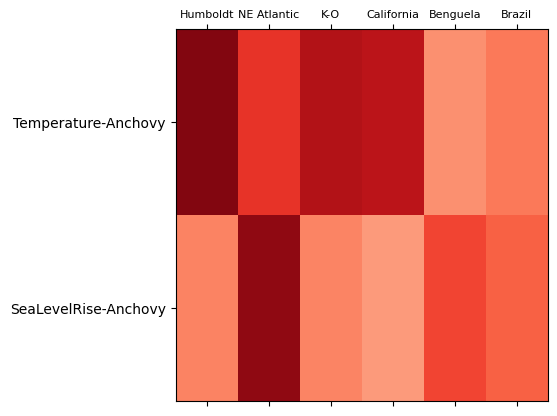

In [44]:
fig3 = plt.matshow(TA1matrix, cmap=plt.cm.Reds, aspect=3, norm = matplotlib.colors.Normalize(vmin=0, vmax=0.2, clip=False))
labels=['Humboldt','NE Atlantic','K-O','California','Benguela','Brazil']
plt.xticks(range(0,6,1), labels=labels, fontsize=8)
plt.yticks(range(0,2,1), labels=['Temperature-Anchovy', 'SeaLevelRise-Anchovy'])

In [41]:
# Humboldt, NE Atlantic, KO, California, Benguela, Brazil-Argentina, 
TS1matrix = [[0.151,0.197,0.134,0.232,0.103,0.150], [0.110,0.107,0.163,0.136,0.097,0.120]]

([<matplotlib.axis.YTick at 0x183500cd820>,
 [Text(0, 0, 'Temperature-Sardine'), Text(0, 1, 'SeaLevelRise-Sardine')])

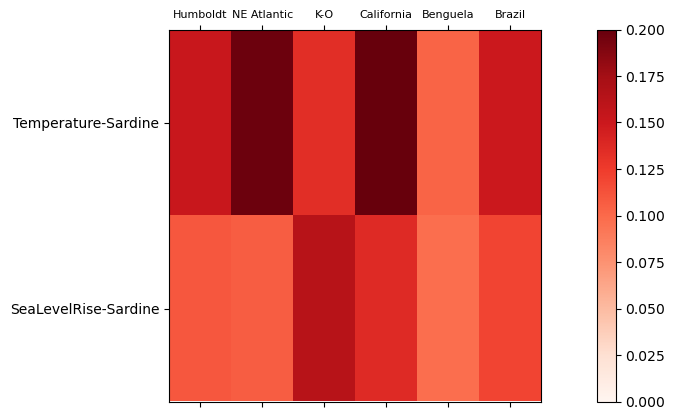

In [43]:
fig4 = plt.matshow(TS1matrix, cmap=plt.cm.Reds, aspect=3, norm = matplotlib.colors.Normalize(vmin=0, vmax=0.2, clip=False))
plt.colorbar(fig4)
labels=['Humboldt','NE Atlantic','K-O','California','Benguela','Brazil']
plt.xticks(range(0,6,1), labels=labels, fontsize=8)
plt.yticks(range(0,2,1), labels=['Temperature-Sardine', 'SeaLevelRise-Sardine'])

In [15]:
# detect network entropy

mci_dif_tau = []

for tau_var in range(0, 11):
    # construct mci_sum set
    mcisum = []
    results = pcmci.run_pcmci(tau_max=tau_var, alpha_level=0.1, pc_alpha=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1])
    mci_all = results['val_matrix'].round(2)
    mci_var = []
    for i in range(len(mci_all)):
        mci_var.append(np.mean(mci_all[i], axis=1))
    mci_var = np.array(mci_var)
    # see mci_matrix
    print(mci_var)
    # compute sum of mci
    mcisum.append(np.sum(mci_var))
    # store mcisum for each tau_max
    mci_dif_tau.append(mcisum)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 0
pc_alpha = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 0 link(s):
    [pc_alpha = 0.01]

    Variable $sardine$ has 0 link(s):
    [pc_alpha = 0.01]

    Variable $sio_sst$ has 0 link(s):
    [pc_alpha = 0.01]

    Variable $np_sst$ has 0 link(s):
    [pc_alpha = 0.01]

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 0
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 0 link(s):

    Variable $sardine$ has 0 link(s):

    Variable $sio_sst$ has 1 link(s):
        ($np_sst$  0): pval = 0.00000 | val =  0.547 | unoriented link

    Variable $np_sst$ has 1 link(s):
        ($sio_sst$  0): pval = 0.00000 | val =  0.547 | unoriented link
[[ 0.


    Variable $sio_sst$ has 2 link(s):
    [pc_alpha = 0.04]
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.782
        ($np_sst$ -2): max_pval = 0.03833, min_val =  0.252

    Variable $np_sst$ has 2 link(s):
    [pc_alpha = 0.01]
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.790
        ($np_sst$ -2): max_pval = 0.00047, min_val = -0.416

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 5
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 4 link(s):
        ($sio_sst$  0): pval = 0.00082 | val = -0.405 | unoriented link
        ($np_sst$  0): pval = 0.00344 | val = -0.358 | unoriented link
        ($anchovy$ -1): pval = 0.00468 | val = -0.342
        ($sio_sst$ -3): pval = 0.06985 | val =  0.226

    Variable $sardine$ has 2 link(s):
        ($sardine$ -5): pval = 0.00005 | val =  0.476
        ($np_sst$ -4): pval = 0.06515 | val = -0.230

    Variable $sio_sst$ h


## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
    [pc_alpha = 0.02]
        ($anchovy$ -1): max_pval = 0.01034, min_val = -0.329

    Variable $sardine$ has 2 link(s):
    [pc_alpha = 0.01]
        ($sardine$ -3): max_pval = 0.00006, min_val = -0.498
        ($sardine$ -5): max_pval = 0.00073, min_val =  0.428

    Variable $sio_sst$ has 2 link(s):
    [pc_alpha = 0.05]
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.781
        ($np_sst$ -2): max_pval = 0.04404, min_val = -0.265

    Variable $np_sst$ has 2 link(s):
    [pc_alpha = 0.01]
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.786
        ($np_sst$ -2): max_pval = 0.00118, min_val = -0.412

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 9
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 7 link(s):
        ($sio_sst$  0): pval = 0.00123 | val = -0.418 | unoriented link
    

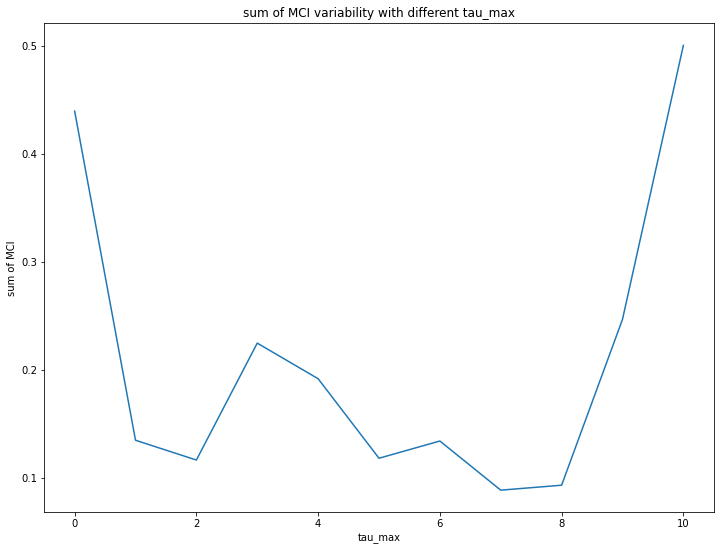

In [16]:
plt.figure(figsize = (12,9))
plt.plot(np.arange(0,11,1), mci_dif_tau)
plt.title('sum of MCI variability with different tau_max')
plt.xlabel('tau_max')
plt.ylabel('sum of MCI')
plt.show()


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.06]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.00482, min_val = -0.329

    Variable $sardine$ has 0 link(s):

    Variable $sio_sst$ has 2 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.768
        ($np_sst$ -2): max_pval = 0.03833, min_val =  0.245

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.757
        ($np_sst$ -2): max_pval = 0.01476, min_val = -0.290

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 3
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 5 link(s):
        ($sio_sst$  0): pval = 0.00103 | val = -0.387 | unoriented link
        ($np_sst$  0): pval = 0

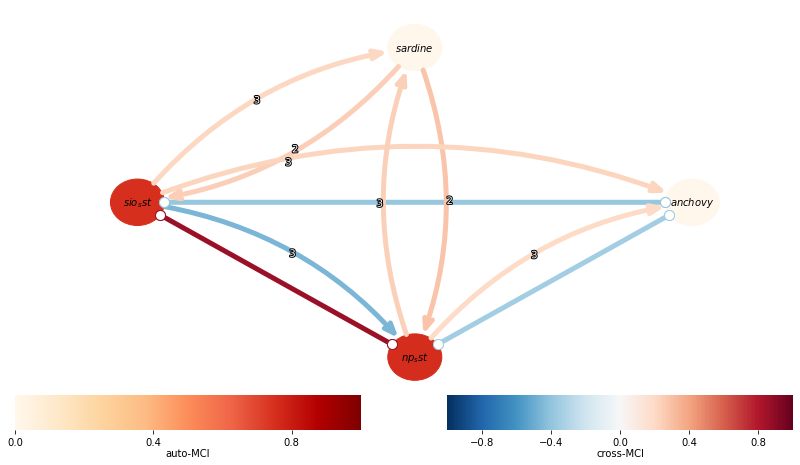

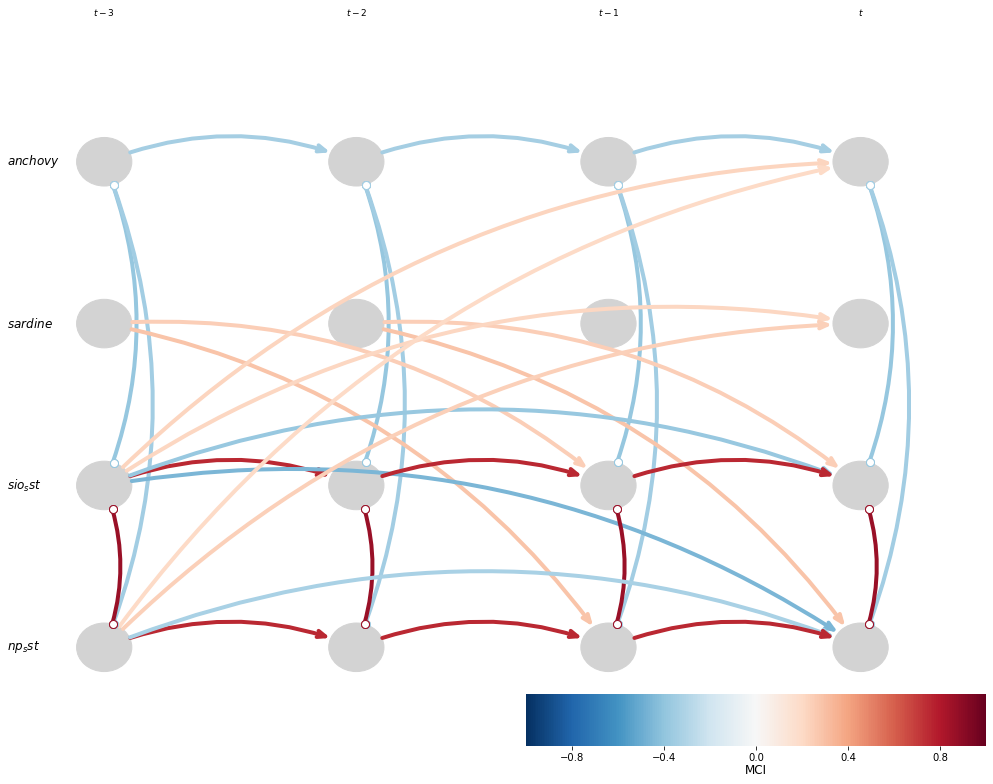

In [36]:
link_matrix0 = pcmci.run_pcmci(tau_max=3, pc_alpha=0.06, alpha_level=0.1)
# Plot casual network
tp.plot_graph(
    figsize=(12,8),
    graph=link_matrix0.get("graph"),
    val_matrix=link_matrix0['val_matrix'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

# Plot time series graph    
tp.plot_time_series_graph(
    graph=link_matrix0.get("graph"),
    figsize=(16, 12),
    val_matrix=link_matrix0['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 0
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 0 link(s):

    Variable $sardine$ has 0 link(s):

    Variable $sio_sst$ has 0 link(s):

    Variable $np_sst$ has 0 link(s):

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 0
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 0 link(s):

    Variable $sardine$ has 0 link(s):

    Variable $sio_sst$ has 1 link(s):
        ($np_sst$  0): pval = 0.00000 | val =  0.547 | unoriented link

    Variable $np_sst$ has 1 link(s):
        ($sio_sst$  0): pval = 0.00000 | val =  0.547 | unoriented link

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 0
pc_alpha = [0.02]
max_con


## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.00425, min_val = -0.329

    Variable $sardine$ has 0 link(s):

    Variable $sio_sst$ has 2 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.791
        ($sio_sst$ -2): max_pval = 0.00204, min_val = -0.355

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.784
        ($np_sst$ -2): max_pval = 0.00021, min_val = -0.420

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 2
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 3 link(s):
        ($sio_sst$  0): pval = 0.00144 | val = -0.371 | unoriented link
        ($anchovy$ -1): pval = 0.00311 | val = -0.342
        ($np_sst$  0): pval = 0.00400 | val = -0.338 | unoriented link

    Variable $sardine$ has 0 link(s):

    Variable $sio_sst$ has 5 link(s):
        ($


## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.00425, min_val = -0.329

    Variable $sardine$ has 0 link(s):

    Variable $sio_sst$ has 1 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.544

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.783
        ($np_sst$ -2): max_pval = 0.00259, min_val = -0.350

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 2
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 3 link(s):
        ($sio_sst$  0): pval = 0.00115 | val = -0.375 | unoriented link
        ($anchovy$ -1): pval = 0.00311 | val = -0.342
        ($np_sst$  0): pval = 0.00400 | val = -0.338 | unoriented link

    Variable $sardine$ has 0 link(s):

    Variable $sio_sst$ has 5 link(s):
        ($np_sst$  0): pval = 0.00000 | val =  0.864 | unoriented link



## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.00482, min_val = -0.329

    Variable $sardine$ has 0 link(s):

    Variable $sio_sst$ has 3 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.768
        ($np_sst$ -2): max_pval = 0.03833, min_val =  0.245
        ($np_sst$ -1): max_pval = 0.06109, min_val = -0.223

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.757
        ($np_sst$ -2): max_pval = 0.01476, min_val = -0.290

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 3
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 5 link(s):
        ($sio_sst$  0): pval = 0.00143 | val = -0.379 | unoriented link
        ($np_sst$  0): pval = 0.00346 | val = -0.347 | unoriented link
        ($anchovy$ -1): pval = 0.00356 | val = -0.342
        ($sio_sst$ -3): pval 


## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.00547, min_val = -0.329

    Variable $sardine$ has 0 link(s):

    Variable $sio_sst$ has 2 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.777
        ($np_sst$ -2): max_pval = 0.03671, min_val =  0.250

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.763
        ($np_sst$ -2): max_pval = 0.02947, min_val = -0.264

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 4
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 5 link(s):
        ($sio_sst$  0): pval = 0.00072 | val = -0.403 | unoriented link
        ($np_sst$  0): pval = 0.00288 | val = -0.359 | unoriented link
        ($anchovy$ -1): pval = 0.00408 | val = -0.342
        ($sio_sst$ -3): pval = 0.06526 | val =  0.227
        ($np_sst$ -3): pval = 0.096


## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.00547, min_val = -0.329

    Variable $sardine$ has 1 link(s):
        ($sardine$ -3): max_pval = 0.07049, min_val = -0.218

    Variable $sio_sst$ has 3 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.777
        ($np_sst$ -2): max_pval = 0.03671, min_val =  0.250
        ($np_sst$ -1): max_pval = 0.05775, min_val = -0.230

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.763
        ($np_sst$ -2): max_pval = 0.02947, min_val = -0.264

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 4
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 5 link(s):
        ($sio_sst$  0): pval = 0.00102 | val = -0.395 | unoriented link
        ($np_sst$  0): pval = 0.00288 | val = -0.359 | unoriented link
        ($anchovy$ -1)

    Variable $sio_sst$ has 2 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.782
        ($np_sst$ -2): max_pval = 0.03833, min_val =  0.252

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.766
        ($np_sst$ -2): max_pval = 0.01581, min_val = -0.296

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 5
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 4 link(s):
        ($sio_sst$  0): pval = 0.00082 | val = -0.405 | unoriented link
        ($np_sst$  0): pval = 0.00344 | val = -0.358 | unoriented link
        ($anchovy$ -1): pval = 0.00468 | val = -0.342
        ($sio_sst$ -3): pval = 0.06985 | val =  0.226

    Variable $sardine$ has 2 link(s):
        ($sardine$ -5): pval = 0.00005 | val =  0.476
        ($np_sst$ -4): pval = 0.06515 | val = -0.230

    Variable $sio_sst$ has 4 link(s):
        ($np_sst$  0): pval = 0


## Significant links at alpha = 0.1:

    Variable $anchovy$ has 4 link(s):
        ($sio_sst$  0): pval = 0.00125 | val = -0.395 | unoriented link
        ($np_sst$  0): pval = 0.00344 | val = -0.358 | unoriented link
        ($anchovy$ -1): pval = 0.00468 | val = -0.342
        ($sio_sst$ -3): pval = 0.06406 | val =  0.233

    Variable $sardine$ has 2 link(s):
        ($sardine$ -5): pval = 0.00005 | val =  0.476
        ($np_sst$ -4): pval = 0.06515 | val = -0.230

    Variable $sio_sst$ has 6 link(s):
        ($np_sst$  0): pval = 0.00000 | val =  0.849 | unoriented link
        ($sio_sst$ -1): pval = 0.00000 | val =  0.543
        ($anchovy$  0): pval = 0.00125 | val = -0.395 | unoriented link
        ($sio_sst$ -3): pval = 0.01263 | val = -0.315
        ($np_sst$ -4): pval = 0.04528 | val =  0.253
        ($sio_sst$ -4): pval = 0.05966 | val =  0.241

    Variable $np_sst$ has 8 link(s):
        ($sio_sst$  0): pval = 0.00000 | val =  0.849 | unoriented link
        ($np_sst$ -

        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.784
        ($np_sst$ -2): max_pval = 0.03836, min_val =  0.256

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.767
        ($np_sst$ -2): max_pval = 0.01579, min_val = -0.301

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 6
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 6 link(s):
        ($sio_sst$  0): pval = 0.00092 | val = -0.407 | unoriented link
        ($np_sst$  0): pval = 0.00366 | val = -0.361 | unoriented link
        ($anchovy$ -1): pval = 0.00536 | val = -0.342
        ($sio_sst$ -3): pval = 0.05865 | val =  0.240
        ($anchovy$ -6): pval = 0.07117 | val =  0.227
        ($np_sst$ -3): pval = 0.08917 | val =  0.216

    Variable $sardine$ has 3 link(s):
        ($sardine$ -5): pval = 0.00016 | val =  0.452
        ($sardine$ -3): pval = 0.04831 | val = -0.248



## Significant links at alpha = 0.1:

    Variable $anchovy$ has 6 link(s):
        ($sio_sst$  0): pval = 0.00141 | val = -0.397 | unoriented link
        ($np_sst$  0): pval = 0.00366 | val = -0.361 | unoriented link
        ($anchovy$ -1): pval = 0.00536 | val = -0.342
        ($sio_sst$ -3): pval = 0.05055 | val =  0.249
        ($anchovy$ -6): pval = 0.07117 | val =  0.227
        ($np_sst$ -3): pval = 0.08917 | val =  0.216

    Variable $sardine$ has 2 link(s):
        ($sardine$ -5): pval = 0.00045 | val =  0.429
        ($sardine$ -3): pval = 0.05698 | val = -0.241

    Variable $sio_sst$ has 6 link(s):
        ($np_sst$  0): pval = 0.00000 | val =  0.850 | unoriented link
        ($sio_sst$ -1): pval = 0.00000 | val =  0.544
        ($anchovy$  0): pval = 0.00141 | val = -0.397 | unoriented link
        ($sio_sst$ -3): pval = 0.01421 | val = -0.315
        ($np_sst$ -4): pval = 0.05690 | val =  0.245
        ($sio_sst$ -4): pval = 0.07090 | val =  0.235

    Variable $np_sst


## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.00800, min_val = -0.329

    Variable $sardine$ has 3 link(s):
        ($sardine$ -5): max_pval = 0.00659, min_val =  0.339
        ($sardine$ -2): max_pval = 0.00821, min_val = -0.330
        ($sardine$ -1): max_pval = 0.02569, min_val =  0.279

    Variable $sio_sst$ has 2 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.793
        ($sio_sst$ -2): max_pval = 0.00609, min_val = -0.342

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.757
        ($np_sst$ -2): max_pval = 0.02512, min_val = -0.284

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 7
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 6 link(s):
        ($sio_sst$  0): pval = 0.00100 | val = -0.411 | unoriented link
        ($np_sst$  0): pval = 


##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 7
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 6 link(s):
        ($sio_sst$  0): pval = 0.00139 | val = -0.403 | unoriented link
        ($np_sst$  0): pval = 0.00325 | val = -0.371 | unoriented link
        ($anchovy$ -1): pval = 0.00615 | val = -0.342
        ($sio_sst$ -3): pval = 0.05444 | val =  0.250
        ($anchovy$ -6): pval = 0.07594 | val =  0.227
        ($np_sst$ -3): pval = 0.09207 | val =  0.218

    Variable $sardine$ has 5 link(s):
        ($sardine$ -5): pval = 0.00255 | val =  0.386
        ($sardine$ -2): pval = 0.00321 | val = -0.377
        ($sardine$ -1): pval = 0.00545 | val =  0.355
        ($np_sst$ -6): pval = 0.05949 | val = -0.247
        ($sardine$ -7): pval = 0.07047 | val =  0.239

    Variable $sio_sst$ has 6 link(s):
        ($np_sst$  0): pval = 0.00000 | val =  0.845 | unoriented link
        


## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.00909, min_val = -0.329

    Variable $sardine$ has 1 link(s):
        ($sardine$ -2): max_pval = 0.00933, min_val = -0.330

    Variable $sio_sst$ has 2 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.795
        ($sio_sst$ -2): max_pval = 0.00869, min_val = -0.333

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.788
        ($np_sst$ -2): max_pval = 0.00095, min_val = -0.413

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 8
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 7 link(s):
        ($sio_sst$  0): pval = 0.00096 | val = -0.419 | unoriented link
        ($np_sst$  0): pval = 0.00336 | val = -0.376 | unoriented link
        ($anchovy$ -1): pval = 0.00705 | val = -0.342
        ($sio_sst$ -3): pva


## Significant links at alpha = 0.1:

    Variable $anchovy$ has 7 link(s):
        ($sio_sst$  0): pval = 0.00101 | val = -0.417 | unoriented link
        ($np_sst$  0): pval = 0.00336 | val = -0.376 | unoriented link
        ($anchovy$ -1): pval = 0.00705 | val = -0.342
        ($anchovy$ -8): pval = 0.05166 | val = -0.252
        ($sio_sst$ -3): pval = 0.05998 | val =  0.246
        ($anchovy$ -6): pval = 0.08104 | val =  0.227
        ($np_sst$ -3): pval = 0.08771 | val =  0.224

    Variable $sardine$ has 3 link(s):
        ($sardine$ -2): pval = 0.00012 | val = -0.479
        ($sardine$ -1): pval = 0.00233 | val =  0.386
        ($sardine$ -5): pval = 0.01099 | val =  0.332

    Variable $sio_sst$ has 4 link(s):
        ($np_sst$  0): pval = 0.00000 | val =  0.843 | unoriented link
        ($sio_sst$ -1): pval = 0.00000 | val =  0.767
        ($anchovy$  0): pval = 0.00101 | val = -0.417 | unoriented link
        ($sio_sst$ -3): pval = 0.00335 | val = -0.379

    Variable $np_ss


## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.01251, min_val = -0.318

    Variable $sardine$ has 3 link(s):
        ($sardine$ -2): max_pval = 0.00933, min_val = -0.330
        ($sardine$ -1): max_pval = 0.01654, min_val =  0.303
        ($sardine$ -5): max_pval = 0.06031, min_val =  0.244

    Variable $sio_sst$ has 2 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.784
        ($np_sst$ -2): max_pval = 0.03803, min_val = -0.269

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.762
        ($np_sst$ -2): max_pval = 0.02285, min_val = -0.293

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 8
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 7 link(s):
        ($sio_sst$  0): pval = 0.00101 | val = -0.417 | unoriented link
        ($np_sst$  0): pval = 0


## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.01034, min_val = -0.329

    Variable $sardine$ has 2 link(s):
        ($sardine$ -3): max_pval = 0.00006, min_val = -0.498
        ($sardine$ -5): max_pval = 0.00073, min_val =  0.428

    Variable $sio_sst$ has 1 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.781

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.786
        ($np_sst$ -2): max_pval = 0.00118, min_val = -0.412

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 9
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 6 link(s):
        ($sio_sst$  0): pval = 0.00083 | val = -0.427 | unoriented link
        ($np_sst$  0): pval = 0.00417 | val = -0.374 | unoriented link
        ($anchovy$ -1): pval = 0.00810 | val = -0.342
        ($anchovy$ -8): pva


## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.01034, min_val = -0.329

    Variable $sardine$ has 2 link(s):
        ($sardine$ -3): max_pval = 0.00006, min_val = -0.498
        ($sardine$ -5): max_pval = 0.00073, min_val =  0.428

    Variable $sio_sst$ has 2 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.781
        ($np_sst$ -2): max_pval = 0.04404, min_val = -0.265

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.761
        ($np_sst$ -2): max_pval = 0.02554, min_val = -0.293

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 9
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 7 link(s):
        ($sio_sst$  0): pval = 0.00123 | val = -0.418 | unoriented link
        ($np_sst$  0): pval = 0.00417 | val = -0.374 | unoriented link
        ($anchovy$ -1


## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.01183, min_val = -0.328

    Variable $sardine$ has 2 link(s):
        ($sardine$ -3): max_pval = 0.00033, min_val = -0.463
        ($sardine$ -2): max_pval = 0.00910, min_val = -0.346

    Variable $sio_sst$ has 1 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.786

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.767
        ($np_sst$ -2): max_pval = 0.02355, min_val = -0.302

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 10
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 6 link(s):
        ($sio_sst$  0): pval = 0.00086 | val = -0.433 | unoriented link
        ($np_sst$  0): pval = 0.00367 | val = -0.385 | unoriented link
        ($anchovy$ -1): pval = 0.00938 | val = -0.341
        ($anchovy$ -8): pv

        ($sardine$ -3): max_pval = 0.00033, min_val = -0.463
        ($sardine$ -2): max_pval = 0.00910, min_val = -0.346

    Variable $sio_sst$ has 2 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.786
        ($np_sst$ -2): max_pval = 0.05305, min_val = -0.260

    Variable $np_sst$ has 2 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.767
        ($np_sst$ -2): max_pval = 0.02355, min_val = -0.302

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 10
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 7 link(s):
        ($sio_sst$  0): pval = 0.00121 | val = -0.425 | unoriented link
        ($np_sst$  0): pval = 0.00367 | val = -0.385 | unoriented link
        ($anchovy$ -1): pval = 0.00938 | val = -0.341
        ($anchovy$ -8): pval = 0.06009 | val = -0.253
        ($sio_sst$ -3): pval = 0.06318 | val =  0.252
        ($np_sst$ -3): pval = 0.08393 


## Resulting lagged parent (super)sets:

    Variable $anchovy$ has 1 link(s):
        ($anchovy$ -1): max_pval = 0.01600, min_val = -0.318

    Variable $sardine$ has 2 link(s):
        ($sardine$ -3): max_pval = 0.00033, min_val = -0.463
        ($sardine$ -2): max_pval = 0.00910, min_val = -0.346

    Variable $sio_sst$ has 2 link(s):
        ($sio_sst$ -1): max_pval = 0.00000, min_val =  0.786
        ($np_sst$ -2): max_pval = 0.05305, min_val = -0.260

    Variable $np_sst$ has 3 link(s):
        ($np_sst$ -1): max_pval = 0.00000, min_val =  0.767
        ($np_sst$ -2): max_pval = 0.02355, min_val = -0.302
        ($sardine$ -10): max_pval = 0.08624, min_val =  0.231

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 10
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.1:

    Variable $anchovy$ has 7 link(s):
        ($sio_sst$  0): pval = 0.00121 | val = -0.425 | unoriented link
        ($np_sst$  0): pval =

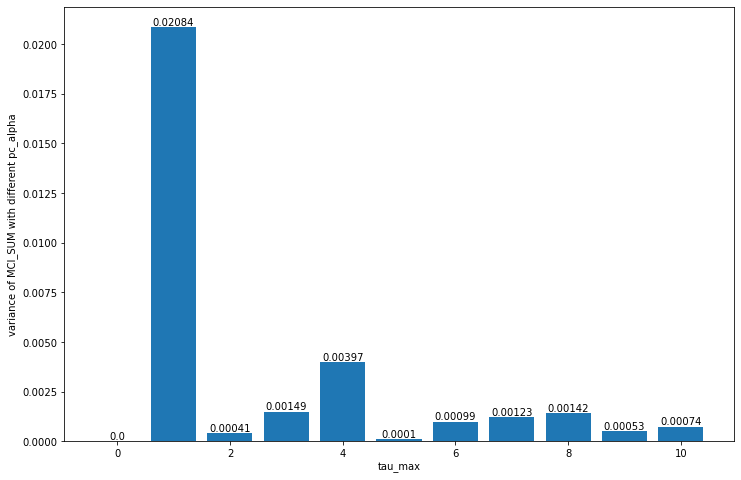

In [51]:
# detect network entropy

mci_difvar_tau = []

for tau_var in range(0, 11):
    # construct mci_sum set
    mcisum = []
    for alpha in np.linspace(0.01, 0.11, 10, endpoint=False):
        results = pcmci.run_pcmci(tau_max=tau_var, alpha_level=0.1, pc_alpha=alpha)
        mci_all = results['val_matrix'].round(2)
        mci_var = []
        for i in range(len(mci_all)):
            mci_var.append(np.mean(mci_all[i], axis=1))
        mci_var = np.array(mci_var)
        # compute sum of mci
        mcisum.append(np.sum(mci_var))
    # store variance of mcisum for each tau_max
    mci_difvar_tau.append(np.var(mcisum))

print(np.array(mci_difvar_tau).round(5))

x = np.linspace(0, 11, 11, endpoint=False)
y = np.array(mci_difvar_tau).round(5)

plt.figure(figsize=(12,8))
plt.bar(x, y)
for a, b in zip(x, y):
    plt.text(a, b, b, ha='center', va='bottom')
plt.xlabel('tau_max')
plt.ylabel('variance of MCI_SUM with different pc_alpha')
plt.show()